# Portfolio optimisation using Efficient Frontier with Sharpe ratio maximisation.

This project will try to find the optimal weigths for each assets in the multi-asset portfolio using 2 methods, Scipy and PyPortfolioOpt. We aim to maximise the Sharpe ratio, recall that the Sharpe ratio is defined as
$$ S_p = \cfrac{\mathbb{E}[R - r]}{\sigma_p}  $$
where $S_p$ is the Sharpe ratio of the portfolio and $R$ is the asset (annual) return, $r$ is the risk-free rate, and $\sigma_p$ is the (annual) volatility of the portfolio.


In [223]:
# importing dependencies
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Selecting assets to be in our portfolio

In [224]:
# choosing assests for our portfolio
stocks_list = ['JPM', 'WELL', 'TSLA', 'MSFT']

In [225]:
# reading the close from the past two years for each asset
df = pd.DataFrame()

for stocks in stocks_list:
    data = yf.Ticker(stocks).history(period = 'max')[-504:]
    df[stocks] = data['Close']
    df.index = data.index

df = df.dropna()
df.head()

,JPM,WELL,TSLA,MSFT
Date,,,,
2021-08-25 00:00:00-04:00,151.684586,79.849495,237.066666,296.635956
2021-08-26 00:00:00-04:00,152.466949,79.642555,233.720001,293.767883
2021-08-27 00:00:00-04:00,153.692352,80.554962,237.306671,294.386688
2021-08-30 00:00:00-04:00,151.232132,80.667839,243.636673,298.187775
2021-08-31 00:00:00-04:00,150.770264,82.332741,245.240005,296.508270


## Assigning weights

In [226]:
# assigning weighs to our portfolio
# for example purposes, we will just use random weights
weights = np.random.random(len(stocks_list))
weights /= np.sum(weights) # normalised the weights
weights

array([0.01888835, 0.33994446, 0.38847202, 0.25269516])

## Computing the daily simple return for each assets in our portfolio

In [227]:
# creating a dataframe of daily log return
df_returns = np.log(1 + df.pct_change())
df_returns = df_returns.dropna()
df_returns.head()

,JPM,WELL,TSLA,MSFT
Date,,,,
2021-08-26 00:00:00-04:00,0.005145,-0.002595,-0.014218,-0.009716
2021-08-27 00:00:00-04:00,0.008005,0.011391,0.015229,0.002104
2021-08-30 00:00:00-04:00,-0.016137,0.001400,0.026325,0.012829
2021-08-31 00:00:00-04:00,-0.003059,0.020429,0.006559,-0.005648
2021-09-01 00:00:00-04:00,-0.001439,0.007399,-0.002218,-0.000166


In [228]:
df_returns.mean()

JPM    -0.000062
WELL    0.000029
TSLA    0.000013
MSFT    0.000169
dtype: float64

## Computing the covariance matrix of our portfolio.

In [229]:
# computing the annualised covariance matrix
covM = df_returns.cov() * 252
covM

,JPM,WELL,TSLA,MSFT
JPM,0.069073,0.022508,0.052486,0.030395
WELL,0.022508,0.073658,0.030011,0.025303
TSLA,0.052486,0.030011,0.382822,0.089732
MSFT,0.030395,0.025303,0.089732,0.095114


## Computing the variance of our portfolio
The variance of the portfolio, $ \sigma_p^2 $,  with $ n $ assets denoted by $ r_j  $ for $ j = 1 , \dots, n $, can be computed by
$$ \sigma_p^2 = \sum\limits_{j =1 }^{n } \sum\limits_{i =1 }^{n } w_j w_i \text{Cov }(r_j , r_i) = \sum\limits_{j =1 }^{n } w_j \sum\limits_{i =1 }^{n } w_i \text{Cov }(r_j , r_i) $$
and the above expression can be simplifed as
$$ \sigma_p^2 = \boldsymbol{w}^T \boldsymbol{\Sigma}  \boldsymbol{w}$$
where $ \boldsymbol{w} $ is the weights vector and $ \Sigma $ is the covarince matrix of the portfolio

In [230]:
variance_p = np.dot(weights.T, np.dot(covM, weights))
variance_p

0.10362235241088494

## Computing the portfolio volitility

In [231]:
# computing the portfolio volility by taking square root portfolio variance
vol_p= np.sqrt(variance_p)
vol_p

0.32190425969670694

## Computing annual portfolio return

In [232]:
annual_return_p = np.sum(df_returns.mean() * weights) * 252
annual_return_p

0.014224033913098223

## Getting risk-free rate from FRED API


In [233]:
pip install fredapi

In [234]:
from fredapi import Fred
fred = Fred(api_key = '5306b4ab6324f2eb804f85e948176784')
treasury_rate = fred.get_series_latest_release('GS10') / 100

rfr = treasury_rate.iloc[-1]
rfr

0.039

## Portfolio performance before optimisation

In [235]:
print('Expected portfolio return: ', annual_return_p * 100, '%')
print('Annual volitility or risk: ', vol_p * 100, '%')
print('Sharpe ratio:', (annual_return_p - rfr) / vol_p)

Expected portfolio return:  1.4224033913098222 %
Annual volitility or risk:  32.19042596967069 %
Sharpe ratio: -0.07696687863107278


# A graph of the Efficient Frontier line by sampling random weights

In [236]:
# initialising empty lists to store weights, returns, volatility or std deviation of portoflio
returns = []
weights_ls = []
stds = []

for _ in range(100000):
  w = np.random.random(len(stocks_list))
  w /= np.sum(w)
  weights_ls.append(w)
  returns.append(np.sum(df_returns.mean() * w) * 252)
  stds.append(np.sqrt(np.dot(w.T, np.dot(covM, w))))

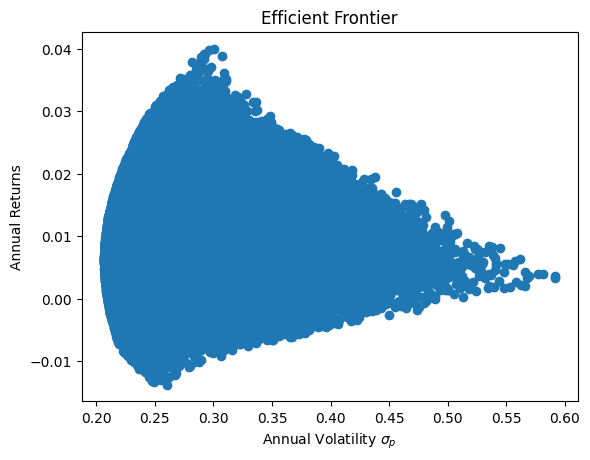

In [237]:
# graphing the efficient frontier
plt.scatter(stds, returns)
plt.title('Efficient Frontier')
plt.xlabel('Annual Volatility $\\sigma_p$')
plt.ylabel('Annual Returns')
plt.show()

An unexpected pizza shape Efficient frontier plot.

# Optimising the portfolio using Scipy minimise on Sharpe ratio

In [238]:
from scipy.optimize import minimize

In [239]:
# now we define a function to be minimised
# we need to minimised the negative of the Sharpe ratio to get the maximum Sharpe ratio

def neg_Sr(weights, returns, covM, rfr):
  """
  Input:
  weights -> the weights of the asset in the portfolio
  returns -> dataframe of pct_change
  covM -> covariance matrix of returns dataframe defined above
  rfr -> risk-free rate
  Output: the negative of Sharpe ratio
  """
  exp_returns = np.sum(returns.mean() * weights) * 252
  std = np.sqrt(np.dot(weights.T, np.dot(covM, weights)))
  return - ((exp_returns - rfr) / std)

In [240]:
# Setting boundaries and constraints for the minimisation
constraints = {'type' : 'eq', 'fun': lambda weights : np.sum(weights) - 1} # setting the sum of weights to be 1
bounds = [(0, 1) for _ in range(len(stocks_list))] # the invidivual weights can range between 0 and 1 inclusive

In [241]:
optimized_result = minimize(neg_Sr, weights, args = (df_returns, covM, rfr), method = 'SLSQP', bounds = bounds, constraints = constraints)

In [242]:
# retrieving the optimised weights
opt_weights = optimized_result.x

In [243]:
# printing out the weights for each assets
for s, w in zip(stocks_list, opt_weights):
  print('Optimal weights for {0} : {1:.2f}'.format(s, w))

Optimal weights for JPM : 0.00
Optimal weights for WELL : 0.00
Optimal weights for TSLA : 0.00
Optimal weights for MSFT : 1.00


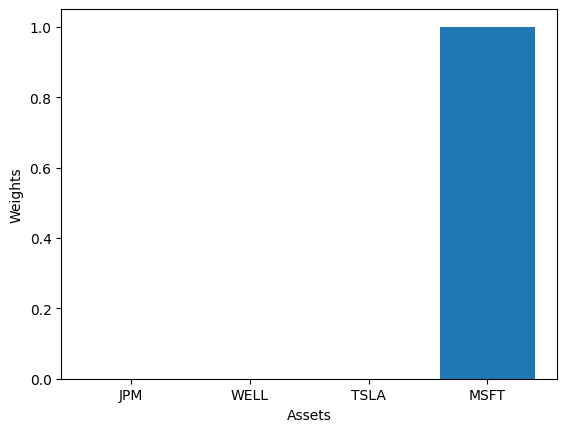

In [244]:
# visualisation of weights distribution
plt.bar(stocks_list, opt_weights)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.show()

## Portfolio performance with Scipy.optimize optimisation of our portfolio when the bound is $(0,1)$

In [245]:
variance_p = np.dot(opt_weights.T, np.dot(covM, opt_weights))
vol_p = np.sqrt(variance_p)
annual_return_p = np.sum(df_returns.mean() * opt_weights) * 252

print('Expected portfolio return: ', annual_return_p * 100, '%')
print('Annual volitility or risk: ', vol_p * 100, '%')
print('Sharpe ratio:', (annual_return_p - rfr) / vol_p)

Expected portfolio return:  4.262697075122872 %
Annual volitility or risk:  30.840627810345566 %
Sharpe ratio: 0.011760366142780147


## Experimental: Setting the constraints of the weights to only be in $(0, 0.5)$

In [246]:
# setting bounds to be in btw (0, 0.5)
bounds = [(0, 0.5) for _ in range(len(stocks_list))]

In [247]:
optimized_result = minimize(neg_Sr, weights, args = (df_returns, covM, rfr), method = 'SLSQP', bounds = bounds, constraints = constraints)

In [248]:
# retrieving the optimal weights with new bounds
opt_weights = optimized_result.x

# reading of the optimal weights
for s, w in zip(stocks_list, opt_weights):
  print('Optimal weights for {0} : {1:.2f}'.format(s, w))

Optimal weights for JPM : 0.00
Optimal weights for WELL : 0.00
Optimal weights for TSLA : 0.50
Optimal weights for MSFT : 0.50


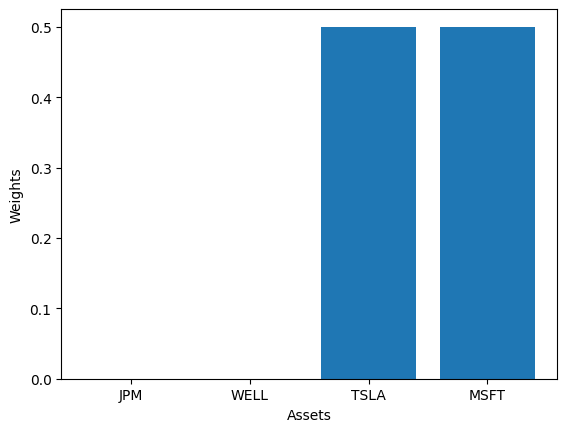

In [249]:
# visualisation of the new weights distribution
plt.bar(stocks_list, opt_weights)
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.show()

## Portfolio performance with Scipy.optimize optimisation of our portfolio when the bound is $(0,0.5)$

In [250]:
variance_p = np.dot(opt_weights.T, np.dot(covM, opt_weights))
vol_p = np.sqrt(variance_p)
annual_return_p = np.sum(df_returns.mean() * opt_weights) * 252

print('Expected portfolio return: ', annual_return_p * 100, '%')
print('Annual volitility or risk: ', vol_p * 100, '%')
print('Sharpe ratio:', (annual_return_p - rfr) / vol_p)

Expected portfolio return:  2.29179666320712 %
Annual volitility or risk:  40.54011805940439 %
Sharpe ratio: -0.03966942904399887


# Optimising the portfolio using PyPortfolioOpt package

In [262]:
# installing the required package (if have not already)
# pip install PyPortfolioOpt


In [259]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

## Calculating expected returns

In [260]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
mu

JPM    -0.015426
WELL    0.007380
TSLA    0.003214
MSFT    0.043549
dtype: float64

## Optimise for max sharpe ratio

In [261]:
ef = EfficientFrontier(mu, S)
weight = ef.max_sharpe(risk_free_rate = rfr)
cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('JPM', 0.0), ('WELL', 0.0), ('TSLA', 0.0), ('MSFT', 1.0)])

In [257]:
# reading the expected performance of our portfolio
ef.portfolio_performance(verbose = True, risk_free_rate = rfr)

Expected annual return: 4.4%
Annual volatility: 30.9%
Sharpe Ratio: 0.01


(0.04354854810530905, 0.3087891779102639, 0.014730270458606842)

Result is pretty similar to using Scipy.optimize, I suspect the slight difference is due to the weights used are "cleaned" and rounded up.